In [1]:
import tensorflow as tf
from common.tf_util import get_session
from common.cmd_util import make_vec_env
from common.policies import build_policy
from ppo2.runner import Runner
import gym, os
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from ppo2.model import Model
from common.ah_env import in_hull
import pickle

def build_env(env_id,seed,with_obs=0,obs_idx=20,ah_with_goal_loc=0,ah_goal_loc_idx=8,ah_with_reach_goal=1,ctrl_rwd=1,ctrl_rwd_coef=1,goal_height=1.0,env_type='corl',with_obs_end=1,sparse=0,obs_pen=1e6,final_rwd=0.,horizon=2000,ho=0):
    config = tf.ConfigProto(allow_soft_placement=True,intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    config.gpu_options.allow_growth = True
    get_session(config=config)
    env = make_vec_env(env_id, env_type, horizon, with_obs, with_obs_end, obs_idx, obs_pen, sparse, ah_with_goal_loc, ah_goal_loc_idx, ah_with_reach_goal, ctrl_rwd, final_rwd, ctrl_rwd_coef, ho, goal_height, 1, seed, reward_scale=1.0, flatten_dict_observations=True)
    return env

def prepare(env_id,seed,horizon,with_obs,with_obs_end,obs_idx,obs_pen,sparse,ah_with_goal_loc,ah_goal_loc_idx,ah_with_reach_goal,ctrl_rwd,final_rwd,load_path,model,ho=0):
    env=build_env(env_id,seed=seed,with_obs=with_obs,obs_idx=obs_idx,ah_with_goal_loc=ah_with_goal_loc,ah_goal_loc_idx=ah_goal_loc_idx,ah_with_reach_goal=ah_with_reach_goal,ctrl_rwd=ctrl_rwd,with_obs_end=with_obs_end,sparse=sparse,obs_pen=obs_pen,final_rwd=final_rwd,horizon=horizon,ho=ho)
    model.load(load_path)
    runner = Runner(env=env, model=model, nsteps=2048, gamma=0.99, lam=0.95)
    return model,runner

def eval_ah(set_path,filesave_pre,run_idx,plan_path,with_obs,goal_loc,big_goal_radius,obs_dist,H1,H2,H1D,H2D,Obs=None):
    initial_state=plan_path[0,:2]
    fig, ax = plt.subplots(figsize=(8,3.5))
    H = np.concatenate((np.array(H1)[:,:], H2), axis=0)
    pgon = plt.Polygon(H, color='y', alpha=1, zorder=0)
    ax.add_patch(pgon)
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), big_goal_radius, color='m')
    ax.add_artist(goal_plan)
    plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(run_idx), fontsize=20)
    if with_obs:
        for o in Obs:
            if in_hull(np.array(o[:2]),H1D,H2D):
                if np.linalg.norm(goal_loc-o[:2])>big_goal_radius+obs_dist:
                    obstacle = plt.Circle(o[:2], obs_dist, color=[0.4,0.4,0.4])#, zorder=10)
                    ax.add_artist(obstacle)
    plt.plot(initial_state[0], initial_state[1], 'ok', markersize=16, color ='r')
    plt.plot(plan_path[:,0],plan_path[:,1],'-k',label='Planned Path')
    plt.ylim([60, 140])
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.legend()
    plt.savefig(set_path+filesave_pre+'.png',dpi=200)
    plt.show()
    return plan_path

In [2]:
#ho==0: with_goal_loc with_obs seed 1 best; no_goal_loc with_obs seed 0 best
#ho==0.999, no sparse, with_goal_loc: lr 0.1 with_obs seed 1 best(only works for 0 and 2); 
#ho==0.999, sparse, no_goal_loc:  (if only look at final update: lr 0.1 goal loc 8 with_obs seed 7 best;)
#lr 0.05 goal loc 0 with_obs seed 0 update 4653;
#lr 0.05 goal loc 2 with_obs seed 0 update 850;
#lr 0.05 goal loc 7 with_obs seed 4 update 1500; 
#lr 0.1 goal loc 8 with_obs seed 4 update 3755;
#lr 0.1 goal loc 15 with_obs seed 4 update 3732; 

with_obs=1
obs_idx=20
ah_with_reach_goal=1
ctrl_rwd=1
with_obs_end=1
horizon=2000

ho=0.999
ah_with_goal_loc=1
str_test_idx='2'
dt={'0':[0.05,0,4653],'2':[0.05,0,850],'7':[0.05,4,1500],'8':[0.1,4,3755],'15':[0.1,4,3732]}

if ho==0:
    sparse=0
    real_obs_pen=4e4
    find_best=0
    lr=0.1
    test_idx_ls=[15,0,2,7,8]
    if ah_with_goal_loc:
        best_sd=1
    else:
        best_sd=0
elif ho==0.999:
    if ah_with_goal_loc:
        sparse=0
        real_obs_pen=4e4
        find_best=0
        lr=0.1
        best_sd=1
        test_idx_ls=[0,2]
    else:
        sparse=1
        real_obs_pen=1e6
        find_best=1
        lr,best_sd,best_update=dt[str_test_idx]
        test_idx_ls=[int(str_test_idx)]
    
model_fn = Model
env_id='ah'
env=build_env(env_id,0,with_obs,obs_idx,ah_with_goal_loc,15,ah_with_reach_goal,ctrl_rwd,with_obs_end=with_obs_end,sparse=sparse,obs_pen=1e6,final_rwd=0.,horizon=2000,ho=ho)
ob_space = env.observation_space
ac_space = env.action_space
policy = build_policy(env, 'mlp', value_network='copy')
model = model_fn(policy=policy, env_type='corl', ob_space=ob_space, ac_space=ac_space, nbatch_act=1, nbatch_train=64,ent_coef=0.0, vf_coef=0.5,max_grad_norm=0.5, comm=None, mpi_rank_weight=1)

Logging to /var/folders/h2/zl4wv27s7_l5c_09wvwjdl_80000gn/T/openai-2020-08-19-03-30-44-073029


OK!
OK!
OK!
OK!
-28686.584278


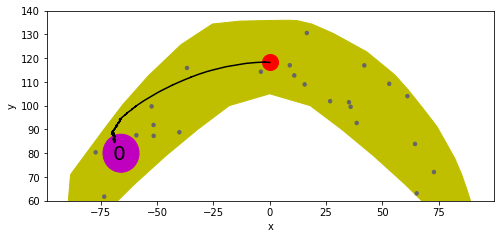

891
OK!
OK!
OK!
OK!
OK!
OK!
OK!
-15505.8682


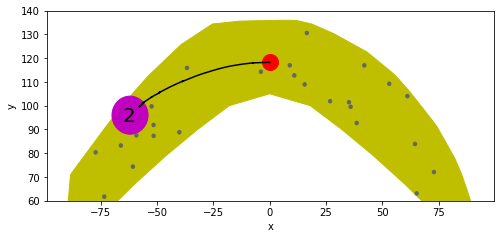

471


In [3]:
#for obs_pen in [1e5]:
#for obs_pen in [4e4]:
#for obs_pen in [1e6]:
for obs_pen in [real_obs_pen]:
    final_rwd=0.
    #for ah_goal_loc_idx in [15,0,2,7,8]:
    for ah_goal_loc_idx in test_idx_ls:
        folder_suf=''
        
        if ah_with_reach_goal:
            folder_suf+='_withreachgoal'
        else:
            folder_suf+='_noreachgoal'
            
        if not sparse:
            if ctrl_rwd:
                folder_suf+='_ctrl1'
            else:
                folder_suf+='_noctrl'
        else:
            folder_suf+='_sparse'
        
        res_folder='../beliefspaceplanning/rollout_node/set/'

        if obs_idx==14:
            model_pre='no_goal_loc'
            final_ah_goal_loc_idx=0
            big_goal_radius=5.
            obs_dist=0.5
            res_folder+='set21c_policy_nogoalloc'
            eval_steps=horizon
            
        else:
            final_ah_goal_loc_idx=ah_goal_loc_idx
            big_goal_radius=8.
            obs_dist=0.75
            if ah_with_goal_loc:
                eval_steps=horizon*2
                model_pre='with_goal_loc'
                res_folder+='set20c_policy_withgoalloc'
            else:
                if ho==0.999:
                    eval_steps=horizon*4
                elif ho==0:
                    eval_steps=horizon*1
                model_pre='no_goal_loc_'+str(ah_goal_loc_idx)
                res_folder+='set20c_policy_nogoalloc'
        
        if with_obs:
            if ho!=0:
                res_folder+='_OBS_ho'+str(ho)+'/'
            else:
                res_folder+='_OBS/'
            model_pre+='_withobs_numsteps_7_lr_'+str(lr)
            with open('./obs_'+str(obs_idx)+'.pkl', 'rb') as f: 
                Obs = pickle.load(f,encoding='latin')
        else:
            if ho!=0:
                res_folder+='_ho'+str(ho)+'/'
            else:
                res_folder+='/'
            model_pre+='_noobs_numsteps_7_lr_'+str(lr)
            Obs=None

        if with_obs_end:
            suf_suf=''
        else:
            suf_suf='_noobsend'
        if obs_pen!=1e6:
            suf_suf+='_pen'+str(int(obs_pen))
        if final_rwd!=0.:
            suf_suf+='_frwd'+str(int(final_rwd))
        if horizon!=2000:
            suf_suf+='_h'+str(horizon)


        for seed in range(best_sd,best_sd+1):
            load_path='./ppo2_results/models/test_ah'+folder_suf+'/numsteps_7_lr_'+str(lr)+'/obs_idx_'+str(obs_idx)+'/'+model_pre+folder_suf+suf_suf+'_seed_'+str(seed)
            if ho!=0:
                load_path='./ppo2_results/models/test_ah'+folder_suf+'/numsteps_7_lr_'+str(lr)+'/obs_idx_'+str(obs_idx)+'/'+model_pre+folder_suf+suf_suf+'_seed_'+'ho'+str(ho)+'_'+str(seed)
            if find_best:
                load_path+='_find_best_update_'
                load_path+=str(best_update)
            
            model,runner=prepare(env_id,seed,horizon,with_obs,with_obs_end,obs_idx,obs_pen,sparse,ah_with_goal_loc,ah_goal_loc_idx,ah_with_reach_goal,ctrl_rwd,final_rwd,load_path,model,ho=ho)
            for run_idx in [final_ah_goal_loc_idx]:
                obs, returns, masks, actions, values, neglogpacs, states, epinfos, final_obs, succ, best_eps_ret, best_eps_len = runner.run(do_eval=True,num_eval_eps=1,compare=True,compare_ah_idx=run_idx,reacher_sd=run_idx,acrobot_sd=run_idx,eval_steps=eval_steps)
                do_eval_epinfobuf=deque(maxlen=10000)
                do_eval_epinfobuf.extend(epinfos)
                start_idx=0
                found=False
                rwd_ls,idx_ls=[],[]
                for j in range(len(epinfos)):
                    if ah_goal_loc_idx==15 or ah_goal_loc_idx==0:
                        cond=-6e4
                        #cond=-obs_pen
                    else:
                        cond=-obs_pen
                    if np.linalg.norm(final_obs[j][0,:2]-runner.env.goal_loc)<=0.6875*big_goal_radius:
                        rwd_ls.append(epinfos[j]['r'])
                        idx_ls.append(j)
                    '''
                    if epinfos[j]['r']>cond:
                        print(epinfos[j]['r'])
                        observ=obs[start_idx:start_idx+do_eval_epinfobuf[j]['l'],:]
                        actions=actions[start_idx:start_idx+do_eval_epinfobuf[j]['l'],:]
                        observ=np.concatenate([observ,final_obs[j]],axis=0)
                        found=True
                        break
                    start_idx+=epinfos[j]['l']
                    '''
                if len(rwd_ls)!=0:
                    j=np.argmax(rwd_ls)
                    start_idx=0
                    print(rwd_ls[j])
                    found=True
                    for i in range(idx_ls[j]):
                        start_idx+=epinfos[i]['l']
                    observ=obs[start_idx:start_idx+do_eval_epinfobuf[idx_ls[j]]['l'],:]
                    actions=actions[start_idx:start_idx+do_eval_epinfobuf[idx_ls[j]]['l'],:]
                    observ=np.concatenate([observ,final_obs[idx_ls[j]]],axis=0)
                
                
                if found:
                    if not (np.linalg.norm(observ[:,:2]-runner.env.goal_loc,axis=1)<=big_goal_radius).any():
                        print("No reach goal within horizon")
                    else:
                        if np.linalg.norm(observ[-1,:2]-runner.env.goal_loc)>0.6875*big_goal_radius:
                            print("Only reach goal within big goal radius")
                            idxx=np.argmin(np.linalg.norm(observ[:,:2]-runner.env.goal_loc,axis=1))
                            observ=observ[:idxx+1,:]
                            actions=actions[:idxx+1,:]
                        filesave_pre='policy_OBS'+'_seed'+str(seed)+'_goal'+str(run_idx)+'_run0'    
                        if with_obs:
                            filesave_pre+='_withOBS_numsteps_7_lr_'+str(lr)
                        else:
                            filesave_pre+='_noOBS_numsteps_7_lr_'+str(lr)
                        filesave_pre+=folder_suf
                        filesave_pre+=suf_suf
                        if obs_idx==20:
                            if ah_with_goal_loc:
                                filesave_pre+='_withgoalloc'
                            else:
                                filesave_pre+='_nogoalloc'
                            filesave_pre+='_obs0.75'
                        else:
                            filesave_pre+='_obs0.5'
                        if ho!=0:
                            filesave_pre+='_ho'+str(ho)

                        if not os.path.exists(res_folder):
                            os.makedirs(res_folder)
                        actions=np.clip(actions,env.action_space.low,env.action_space.high)
                        np.savetxt(os.path.abspath(res_folder+filesave_pre+'_traj.txt'),observ[:,:4], fmt='%.20f', delimiter=',')
                        np.savetxt(os.path.abspath(res_folder+filesave_pre+'_plan.txt'),actions, fmt='%.20f', delimiter=',')
                        if runner.env.env_name=='ah':
                            eval_ah(res_folder,filesave_pre,run_idx,observ,with_obs,runner.env.goal_loc,big_goal_radius,obs_dist,runner.env.H1,runner.env.H2,runner.env.H1D,runner.env.H2D,Obs=Obs)
                            print(actions.shape[0])  
                else:
                    print("No solution")
                    for j in range(len(epinfos)):
                        #if epinfos[j]['l']==2000:
                        #    continue
                        rwd_ls.append(epinfos[j]['r'])
                        idx_ls.append(j)
            
                    j=np.argmax(rwd_ls)
                    start_idx=0
                    print(rwd_ls[j])
                    for i in range(idx_ls[j]):
                        start_idx+=epinfos[i]['l']
                    observ=obs[start_idx:start_idx+do_eval_epinfobuf[idx_ls[j]]['l'],:]
                    actions=actions[start_idx:start_idx+do_eval_epinfobuf[idx_ls[j]]['l'],:]
                    observ=np.concatenate([observ,final_obs[idx_ls[j]]],axis=0)
                    
                    filesave_pre='policy_OBS'+'_seed'+str(seed)+'_goal'+str(run_idx)+'_run0'    
                    if with_obs:
                        filesave_pre+='_withOBS_numsteps_7_lr_'+str(lr)
                    else:
                        filesave_pre+='_noOBS_numsteps_7_lr_'+str(lr)
                    filesave_pre+=folder_suf
                    filesave_pre+=suf_suf
                    if obs_idx==20:
                        if ah_with_goal_loc:
                            filesave_pre+='_withgoalloc'
                        else:
                            filesave_pre+='_nogoalloc'
                        filesave_pre+='_obs0.75'
                    else:
                        filesave_pre+='_obs0.5'
                    if ho!=0:
                        filesave_pre+='_ho'+str(ho)

                    if not os.path.exists(res_folder):
                        os.makedirs(res_folder)
                    actions=np.clip(actions,env.action_space.low,env.action_space.high)
                    np.savetxt(os.path.abspath(res_folder+filesave_pre+'_traj.txt'),observ[:,:4], fmt='%.20f', delimiter=',')
                    np.savetxt(os.path.abspath(res_folder+filesave_pre+'_plan.txt'),actions, fmt='%.20f', delimiter=',')
                    if runner.env.env_name=='ah':
                        eval_ah(res_folder,filesave_pre,run_idx,observ,with_obs,runner.env.goal_loc,big_goal_radius,obs_dist,runner.env.H1,runner.env.H2,runner.env.H1D,runner.env.H2D,Obs=Obs)
                        print(actions.shape[0])